Lab03
====

##  Context

### Sequence Modeling
+ Recurrent Neural Nets(RNN)

+ Long Short-Term Memory(LSTM)

# 순환 신경망(Recurrent Neural Networks, RNN)
 + 순차적인 데이터, 즉 순서 있는 일련의 값(Sequence Data)들을 처리하는데 특화된 신경망

<img src="./Images/RNN.png" style="height: 250px">
RNN에 입력 벡터 순서열  x1,x2,…,xn  을 차례대로 입력하면 상태 순서열  s1,s2,…,sn 이 내부적으로 생성되고 출력으로는 출력 순서열  o1,o2,…,on  이 나옵니다.

+ x : 입력 벡터
+ o : 출력 벡터
+ s : 상태 벡터(신경망 전체의 상태가 아니라 신경망의 은닉(hidden)단위들의 상태임을 나타내기 위해 변수 이름으로 h를 사용합니다.)
+ U : 입력 대 은닉 연결에 대한 가중치 행렬
+ W : 은닉 대 은닉 연결에 대한 가중치 행렬
+ V : 은닉 대 출력 연결에 대한 가중치 행렬


+ 일반적인 Neural Network와 다른 점 :
    + 뒤쪽으로 향하는 연결 존재 즉, 이전 입력에 의해 만들어진 출력을 입력으로 받습니다.
    
        + 기존의 신경망 구조에서는 모든 입력(과 출력)이 각각 독립적이라고 가정합니다.
        하지만 문장에서 다음에 나올 단어를 추측하고 싶은 경우를 고려해보면, 이전에 나온 단어들을 아는 것은 추측하는 데 큰 도움이 될 것입니다.
    + 매개변수 공유 : 여러 시간 단계가 같은 가중치들을 공유합니다. (깊은 계산 그래프를 통해 매개변수들이 공유됩니다.)
    + 출력 순차열의 각 성분은 출력의 이전 성분의 함수입니다.

## 계산 그래프 펼치기(unfolding)

<img src="./Images/hiddenunit.png"/>
$a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)}$

$h^{(t)} = tanh(a^{(t)})$

$o^{(t)} = c + Vh^{(t)}$

$\hat{y}^{(t)} = softmax(o^{(t)})$

## Back-Propagation Through Time(BPTT)
+ 역전파 알고리즘을 펼쳐진 계산 그래프에 적용하는 것입니다.(순환 신경망에 특화된 새로운 알고리즘을 필요로하지 않습니다.)

## Applications

<img src="./Images/rnncategory.png"/>

원하는 결과가 출력 순서열  $o_1,o_2,…,o_n$  이 target 순서열  $y_1,y_2,…,y_n$  과 같아지는 것이라면 입력 순서열 길이와 출력 순서열 길이가 같은 특수한 경우의 sequnce-to-sequence (many-to-many) 예측 문제가 되고, 순서열의 마지막 출력  $o_n$  값이  $y_n$ 값과 같아지는 것만 목표라면 단순한 sequence to value (many-to-one) 예측 문제가 됩니다.

## 예제 1) 'hihello' 학습시켜보기(many to many)

#### hihello 학습 : hihell -> ihello
+ 한 문자 순서열 값을 통해 다음 시간 스텝의 문자 순서열 값을 예측하도록 학습해보겠습니다.
<img src="./Images/samsungimg.png">

### 입력한 문자열에 대해 그 다음 나와야할 문자열을 예측해 보겠습니다.

In [1]:
#path 관련 라이브러리
from os.path import join, isdir

# Scientific Math 라이브러리  
import numpy as np

# Visualization 라이브러리
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers, models, Input
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Keras 백 엔드인 TensorFlow의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# TensorFlow의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()

# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True

# TensorFlow는 Session이라는 실행 단위를 가지고 있는데, 해당 Session이라는에 적용할 옵션을 담고있는 
sess = tf.Session(config=config)

# 설정한 Session이라는을 현재 프로세스에 적용합니다.
set_session(sess)

## 1. 데이터 생성하기(데이터 살펴보기 + 간단한 전처리)

#### 1.1 유일한 문자들에 대해서 One hot encoding 합니다.
+ 각 문자에 대해서 독립적인 벡터 형태로 표현하기 위함입니다.

__text : 'hihello'__
+ 학습에 사용할 Text 입니다.

__index: h:0, i:1, e:2, l:3, o:4 (dirctionary)__
+ 각 문자(유일한 문자)에 인덱스를 부여한 후 문자열을 인덱스 리스트로 변환하여 이를 one hot encoding 합니다

__유일한 문자 : h, i, e, ㅣ, o__ 
+ 유일한 문자의 수에 의해 one hot encoding size가 결정됩니다.(size = 5))


In [3]:
# sample text
sample = "hihello"

# 유일한 문자들에 대해서 리스트를 만듭니다.
# 문자열 -> 문자 리스트 ['i', 'l', 'e', 'o', 'h']

# set 자료형 변환, set 자료형은 중복을 허용하지 않고, 순서가 없는 형태의 자료값을 반환합니다.
temp = set(sample)
# set 자료값에 대해서 list형으로 변환합니다.
char_set = list(temp)
print('set size : ', len(char_set))
print('char set : ', char_set)

#Class의 수(최종 출력 크기(RNN or softmax... 등의 출력 크기))
num_classes = len(char_set)

# 문자들을 key로 인덱스를 value로 갖는 딕셔너리를 만듭니다.

# enumerate 내장 함수는 입력받은 자료형이 순서가 있다고 보고 순서대로 인덱스를 부여합니다.
# 부여한 인덱스와 값을 반환합니다.
char_dic = {w: i for i, w in enumerate(char_set)}
print('char_dic : ', char_dic)


##참고 : 순서가 없는 set이나 dictionary 자료형은 인덱싱을 지원하지 않습니다.

set size :  5
char set :  ['e', 'h', 'o', 'i', 'l']
char_dic :  {'e': 0, 'h': 1, 'o': 2, 'i': 3, 'l': 4}


####  1.2 Target 데이터를 설정합니다.

In [4]:
# X data 샘플 hihello: hihell (index 0~n-1의 값)
x_str = sample[:-1]

# Y data 샘플 hihello: ihello (index 1~n의 값) < Target >
y_str = sample[1:]

In [5]:
# 문자를 인덱스값으로 변환합니다.
x = [char_dic[c] for c in x_str]  
y = [char_dic[c] for c in y_str]

In [6]:
print('x(= ',x_str,') :', x)
print('y(= ',y_str,') :', y)

x(=  hihell ) : [1, 3, 1, 0, 4, 4]
y(=  ihello ) : [3, 1, 0, 4, 4, 2]


#### 1.3 index에 대응되는 리스트의 값을 1로 합니다.(one-hot encoding)

In [7]:
# One-hot encoding
x = keras.utils.to_categorical(x, num_classes=num_classes)
print(x.shape)

(6, 5)


In [8]:
# One-hot encoding
y = keras.utils.to_categorical(y, num_classes=num_classes)
print(y.shape)

(6, 5)


In [9]:
print('x :\n', x)
print('y :\n', y)

x :
 [[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
y :
 [[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


## 2. keras의 SimpleRNN를 이용해 순환신경망 만들어보기

#### Keras 에서 RNN 을 사용하려면 입력 데이터는 (nb_samples, timesteps, input_dim) 크기를 가지는 ndim=3인 3차원 텐서(tensor) 형태이어야 합니다.

+ nb_samples(= batch_size) : 자료의 수
+ timesteps(= sequemce_length) : 순서열의 길이
+ input_dim(= data_dim) : 입력 벡터의 차원

여기서 text sequence 하나의 차원이 5이므로 input_dim = 5이고, 

sequemce length =  6(hihell, ihello)이며 

nb_samples = 1 입니다.
<br><br>
<br><br>

#### 2.1 입력 데이터 구조 파라미터를 설정합니다.

In [10]:
# RNN의 입력 크기(one-hot size)
data_dim = len(char_dic)

#순서열의 길이
sequence_length = len(x)# unfolding(unit 수)( = len(sample)-1 )

#배치사이즈(one batch size)
batch_size = 1

# RNN cell의 출력 크기(차원)
# hidden_size = len(char_set) = num_classes

<img src="./Images/shape.png">

#### 데이터 구조를 변환합니다.

In [11]:
# x를 
x = np.reshape(x, (-1, sequence_length, data_dim))
print(x.shape)

(1, 6, 5)


In [12]:
# reshape Y => [samples, sequence length(time steps), features(input dim)]
y = np.reshape(y, (-1, len(y), data_dim))
print(y.shape)

(1, 6, 5)


In [13]:
x_train = x
y_train = y
print('x_train :', x_train)
print('y_train :', y_train)

x_train : [[[0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]]
y_train : [[[0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]]]


#### 2.2 학습

In [14]:
# 입력 텐서
# input_shape : input_length 인수로는 순서열의 길이, input_dim 인수로는 벡터의 크기를 입력합니다.
# batch size를 제외한 크기를 입력합니다.
input_shape = (x_train[0].shape)
input_tensor = layers.Input(input_shape)

In [15]:
# 가장 단순한 신경망 구조인 SimpleRNN 클래스를 사용합니다.

# 첫번째 인수 : RNN cell 출력의 크기(차원)를 입력합니다.
# return_sequences : 출력 시퀀스의 마지막 출력을 반환할지 아니면 전체 시퀀스를 반환할지 지정합니다.
rnn_layer = layers.SimpleRNN(num_classes, return_sequences=True)(input_tensor)

# 입력의 모든 시간 슬라이스에 Dense 레이어를 적용합니다.
# 데이터의 형태가 (32, 10, 16)이라고 한다면
# 자료의 수는 32, 순서열의 길이는 10, 입력 벡터의 차원은 18이라는 것을 나타냅니다.
# 이때 순서열 각각에 대해서 Dense 레이어를 통과시킵니다.
# Target의 차원과 layer의 ouput의 차원을 맞춰주는 것입니다,
output_tensor = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'))(rnn_layer)

In [16]:
# 모델 컴파일.
model = models.Model(input_tensor, output_tensor)
model.compile(optimizer = 'Adam',
              # 범주 분류이므로 categorical_crossentropy
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6, 5)              0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 6, 5)              55        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 5)              30        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    verbose=2
                   )

Epoch 1/100
 - 0s - loss: 1.6548 - acc: 0.1667
Epoch 2/100
 - 0s - loss: 1.6506 - acc: 0.1667
Epoch 3/100
 - 0s - loss: 1.6463 - acc: 0.1667
Epoch 4/100
 - 0s - loss: 1.6421 - acc: 0.1667
Epoch 5/100
 - 0s - loss: 1.6378 - acc: 0.1667
Epoch 6/100
 - 0s - loss: 1.6336 - acc: 0.1667
Epoch 7/100
 - 0s - loss: 1.6294 - acc: 0.1667
Epoch 8/100
 - 0s - loss: 1.6252 - acc: 0.1667
Epoch 9/100
 - 0s - loss: 1.6210 - acc: 0.1667
Epoch 10/100
 - 0s - loss: 1.6168 - acc: 0.1667
Epoch 11/100
 - 0s - loss: 1.6126 - acc: 0.1667
Epoch 12/100
 - 0s - loss: 1.6084 - acc: 0.1667
Epoch 13/100
 - 0s - loss: 1.6042 - acc: 0.1667
Epoch 14/100
 - 0s - loss: 1.6000 - acc: 0.1667
Epoch 15/100
 - 0s - loss: 1.5958 - acc: 0.1667
Epoch 16/100
 - 0s - loss: 1.5917 - acc: 0.1667
Epoch 17/100
 - 0s - loss: 1.5875 - acc: 0.1667
Epoch 18/100
 - 0s - loss: 1.5833 - acc: 0.1667
Epoch 19/100
 - 0s - loss: 1.5792 - acc: 0.1667
Epoch 20/100
 - 0s - loss: 1.5750 - acc: 0.1667
Epoch 21/100
 - 0s - loss: 1.5708 - acc: 0.1667
E

#### 2.3 학습 결과 확인

In [19]:
x_train

array([[[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]], dtype=float32)

\* 예측값

In [20]:
temp = model.predict(x_train)
print(temp.shape)
print(temp)

(1, 6, 5)
[[[0.21747965 0.14994061 0.17773423 0.26846102 0.18638453]
  [0.10692081 0.20547199 0.35854834 0.19390461 0.13515428]
  [0.28192377 0.3136969  0.15799086 0.0872134  0.15917513]
  [0.13261203 0.21303669 0.13945279 0.1421281  0.37277037]
  [0.15694578 0.18695231 0.17857365 0.11223695 0.36529127]
  [0.07020963 0.31163898 0.26686752 0.06244451 0.28883937]]]


In [21]:
for i in range(temp.shape[1]):
    argmax = np.argmax(temp[:][0][i])
#     print(argmax)
    print(char_set[argmax])

i
o
h
l
l
h


\* 실제값

In [22]:
print(y_train.shape)
print(y_train)

(1, 6, 5)
[[[0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]]]


In [23]:
for i in range(y_train.shape[1]):
    argmax = np.argmax(y_train[:][0][i])
#     print(argmax)
    print(char_set[argmax])

i
h
e
l
l
o


### 실습 예제 1-2)  문장 학습시켜보기
+ 다른 Text에 대해 적용해 봅니다.

## 1. 데이터 생성하기(데이터 살펴보기 + 간단한 전처리)

#### 1.1 유일한 문자들에 대해서 One hot encoding 합니다.
+ 각 문자에 대해서 독립적인 벡터 형태로 표현하기 위함입니다.


In [24]:
# sample sentence(text)
sentence = ("The Vision 2020 is at the core of our commitment to create a better world full of richer digital experiences, through innovative technology and products."
            "The goal of the vision is to become a beloved brand, an innovative company, and an admired company."
            "For this, we dedicate our efforts to creativity and innovation, shared value with our partners, and our great people.")

print('sentence length : ', len(sentence))

# 유일한 문자들에 대해서 리스트를 만듭니다.
# 문자열 -> 문자 리스트 ['i', 'l', 'e', 'o', 'h', ...]

# set 자료형 변환, set 자료형은 중복을 허용하지 않고, 순서가 없는 형태의 자료값을 반환합니다.
temp = set(sentence)
# set 자료값에 대해서 list형으로 변환합니다.
char_set = list(temp)

print('set size : ', len(char_set))
print('char set : \n', char_set)

#Class의 수(최종 출력 크기(RNN or softmax... 등의 출력 크기))
num_classes = len(char_set)

# 문자들을 key로 인덱스를 value로 갖는 딕셔너리를 만듭니다.

# enumerate 내장 함수는 입력받은 자료형이 순서가 있다고 보고 순서대로 인덱스를 부여합니다.
# 부여한 인덱스와 값을 반환합니다.
char_dic = {w: i for i, w in enumerate(char_set)}
print('char_dic : \n', char_dic)

sentence length :  369
set size :  30
char set : 
 ['e', '0', 'b', 't', 'F', 'd', 'r', 'o', 'n', 'v', 'c', '2', ',', 'w', '.', 'y', 'g', 'f', 'i', ' ', 'h', 'l', 'x', 'T', 'p', 'm', 'V', 's', 'a', 'u']
char_dic : 
 {'e': 0, '0': 1, 'b': 2, 't': 3, 'F': 4, 'd': 5, 'r': 6, 'o': 7, 'n': 8, 'v': 9, 'c': 10, '2': 11, ',': 12, 'w': 13, '.': 14, 'y': 15, 'g': 16, 'f': 17, 'i': 18, ' ': 19, 'h': 20, 'l': 21, 'x': 22, 'T': 23, 'p': 24, 'm': 25, 'V': 26, 's': 27, 'a': 28, 'u': 29}


#### 1.2 Target 데이터를 설정합니다.

In [25]:
# X data sample (index 0~n-1에 해당하는 값)
x_str = sentence[:-1]
# Y data sample (index 1~n에 해당하는 값) < Target >
y_str = sentence[1:]

In [26]:
# 문자를 인덱스값으로 변환합니다.
x = [char_dic[c] for c in x_str]  
y = [char_dic[c] for c in y_str]

In [27]:
print('x(= ',x_str,') :\n', x)
print('y(= ',y_str,') :\n', y)

x(=  The Vision 2020 is at the core of our commitment to create a better world full of richer digital experiences, through innovative technology and products.The goal of the vision is to become a beloved brand, an innovative company, and an admired company.For this, we dedicate our efforts to creativity and innovation, shared value with our partners, and our great people ) :
 [23, 20, 0, 19, 26, 18, 27, 18, 7, 8, 19, 11, 1, 11, 1, 19, 18, 27, 19, 28, 3, 19, 3, 20, 0, 19, 10, 7, 6, 0, 19, 7, 17, 19, 7, 29, 6, 19, 10, 7, 25, 25, 18, 3, 25, 0, 8, 3, 19, 3, 7, 19, 10, 6, 0, 28, 3, 0, 19, 28, 19, 2, 0, 3, 3, 0, 6, 19, 13, 7, 6, 21, 5, 19, 17, 29, 21, 21, 19, 7, 17, 19, 6, 18, 10, 20, 0, 6, 19, 5, 18, 16, 18, 3, 28, 21, 19, 0, 22, 24, 0, 6, 18, 0, 8, 10, 0, 27, 12, 19, 3, 20, 6, 7, 29, 16, 20, 19, 18, 8, 8, 7, 9, 28, 3, 18, 9, 0, 19, 3, 0, 10, 20, 8, 7, 21, 7, 16, 15, 19, 28, 8, 5, 19, 24, 6, 7, 5, 29, 10, 3, 27, 14, 23, 20, 0, 19, 16, 7, 28, 21, 19, 7, 17, 19, 3, 20, 0, 19, 9, 18, 27, 18, 7

#### 1.3 index에 대응되는 리스트의 값을 1로 합니다.(one-hot encoding)

In [28]:
# One-hot encoding
x = keras.utils.to_categorical(x, num_classes=num_classes)
print(x.shape)

(368, 30)


In [29]:
# One-hot encoding
y = keras.utils.to_categorical(y, num_classes=num_classes)
print(y.shape)

(368, 30)


In [30]:
print('x :\n', x)
print('y :\n', y)

x :
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
y :
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 2. keras의 SimpleRNN을 이용해 순환신경망 만들어보기

#### Keras 에서 RNN 을 사용하려면 입력 데이터는 (nb_samples, timesteps, input_dim) 크기를 가지는 ndim=3인 3차원 텐서(tensor) 형태이어야 합니다.

+ nb_samples(= batch_size) : 자료의 수
+ timesteps(= sequemce length) : 순서열의 길이
+ input_dim(= data_dim) : 입력 벡터의 차원
<br><br>
<br><br>

#### 2.1 입력 데이터 구조 파라미터를 설정합니다.

In [31]:
# RNN의 입력 크기(one-hot size)
data_dim = len(char_set)

#순서열의 길이
sequence_length = len(x)# unfolding(unit 수)( = len(sentence)-1)

#배치사이즈(one batch size)
batch_size = 1

# RNN cell의 출력 크기(차원)
# hidden_size = len(char_set)

#### 데이터 구조를 변환합니다.

In [32]:
# reshape X => [samples, sequence length(time steps), features(input dim)]
x = np.reshape(x, (-1, sequence_length, data_dim))
print(x.shape)

(1, 368, 30)


In [33]:
# reshape Y => [samples, sequence length(time steps), features(input dim)]
y = np.reshape(y, (-1, sequence_length, data_dim))
print(y.shape)

(1, 368, 30)


In [34]:
x_train = x
y_train = y
print('x_train :', x_train)
print('y_train :', y_train)

x_train : [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
y_train : [[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


#### 2.2 학습

In [35]:
# 입력 텐서
# input_shape : input_length 인수로는 순서열의 길이, input_dim 인수로는 벡터의 크기를 입력합니다.
# batch size를 제외한 크기를 입력합니다.
input_shape = (x_train[0].shape)
input_tensor = layers.Input(input_shape)

In [36]:
# 가장 단순한 신경망 구조인 SimpleRNN 클래스를 사용합니다.
# 첫번째 인수 : RNN cell 출력의 크기(차원)를 입력합니다.
# return_sequences : 출력 시퀀스의 마지막 출력을 반환할지 아니면 전체 시퀀스를 반환할지 지정합니다.
rnn_layer = layers.SimpleRNN(30, return_sequences=True)(input_tensor)

# 입력의 모든 시간 슬라이스에 Dense 레이어를 적용합니다.
# 데이터의 형태가 (32, 10, 16)이라고 한다면
# 자료의 수는 32, 순서열의 길이는 10, 입력 벡터의 차원은 18이라는 것을 나타냅니다.
# 이때 순서열 각각에 대해서 Dense 레이어를 통과시킵니다.
# Target의 차원과 layer의 ouput의 차원을 맞춰주는 것입니다,
output_tensor = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'))(rnn_layer)


In [37]:
# 모델 컴파일.
model2 = models.Model(input_tensor, output_tensor)
model2.compile(optimizer = 'Adam',
              # 범주 분류이므로 categorical_crossentropy
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [38]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 368, 30)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 368, 30)           1830      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 368, 30)           930       
Total params: 2,760
Trainable params: 2,760
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model2.fit(x_train, y_train,
                    epochs=500,
                    verbose=2
                    )

Epoch 1/500
 - 0s - loss: 3.4581 - acc: 0.0435
Epoch 2/500
 - 0s - loss: 3.4437 - acc: 0.0489
Epoch 3/500
 - 0s - loss: 3.4296 - acc: 0.0516
Epoch 4/500
 - 0s - loss: 3.4158 - acc: 0.0571
Epoch 5/500
 - 0s - loss: 3.4022 - acc: 0.0679
Epoch 6/500
 - 0s - loss: 3.3888 - acc: 0.0788
Epoch 7/500
 - 0s - loss: 3.3755 - acc: 0.0815
Epoch 8/500
 - 0s - loss: 3.3623 - acc: 0.0951
Epoch 9/500
 - 0s - loss: 3.3491 - acc: 0.1033
Epoch 10/500
 - 0s - loss: 3.3359 - acc: 0.1114
Epoch 11/500
 - 0s - loss: 3.3226 - acc: 0.1114
Epoch 12/500
 - 0s - loss: 3.3091 - acc: 0.1033
Epoch 13/500
 - 0s - loss: 3.2955 - acc: 0.1060
Epoch 14/500
 - 0s - loss: 3.2815 - acc: 0.1141
Epoch 15/500
 - 0s - loss: 3.2672 - acc: 0.1250
Epoch 16/500
 - 0s - loss: 3.2524 - acc: 0.1386
Epoch 17/500
 - 0s - loss: 3.2372 - acc: 0.1332
Epoch 18/500
 - 0s - loss: 3.2214 - acc: 0.1495
Epoch 19/500
 - 0s - loss: 3.2052 - acc: 0.1495
Epoch 20/500
 - 0s - loss: 3.1885 - acc: 0.1549
Epoch 21/500
 - 0s - loss: 3.1717 - acc: 0.1603
E

Epoch 171/500
 - 0s - loss: 1.9972 - acc: 0.4266
Epoch 172/500
 - 0s - loss: 1.9907 - acc: 0.4402
Epoch 173/500
 - 0s - loss: 1.9858 - acc: 0.4429
Epoch 174/500
 - 0s - loss: 1.9781 - acc: 0.4429
Epoch 175/500
 - 0s - loss: 1.9735 - acc: 0.4484
Epoch 176/500
 - 0s - loss: 1.9668 - acc: 0.4620
Epoch 177/500
 - 0s - loss: 1.9614 - acc: 0.4592
Epoch 178/500
 - 0s - loss: 1.9575 - acc: 0.4565
Epoch 179/500
 - 0s - loss: 1.9507 - acc: 0.4511
Epoch 180/500
 - 0s - loss: 1.9443 - acc: 0.4647
Epoch 181/500
 - 0s - loss: 1.9416 - acc: 0.4647
Epoch 182/500
 - 0s - loss: 1.9337 - acc: 0.4592
Epoch 183/500
 - 0s - loss: 1.9291 - acc: 0.4538
Epoch 184/500
 - 0s - loss: 1.9237 - acc: 0.4484
Epoch 185/500
 - 0s - loss: 1.9185 - acc: 0.4701
Epoch 186/500
 - 0s - loss: 1.9122 - acc: 0.4701
Epoch 187/500
 - 0s - loss: 1.9076 - acc: 0.4674
Epoch 188/500
 - 0s - loss: 1.9020 - acc: 0.4620
Epoch 189/500
 - 0s - loss: 1.8977 - acc: 0.4674
Epoch 190/500
 - 0s - loss: 1.8947 - acc: 0.4864
Epoch 191/500
 - 0s 

 - 0s - loss: 1.4359 - acc: 0.6386
Epoch 339/500
 - 0s - loss: 1.4329 - acc: 0.6413
Epoch 340/500
 - 0s - loss: 1.4300 - acc: 0.6440
Epoch 341/500
 - 0s - loss: 1.4271 - acc: 0.6467
Epoch 342/500
 - 0s - loss: 1.4242 - acc: 0.6467
Epoch 343/500
 - 0s - loss: 1.4213 - acc: 0.6495
Epoch 344/500
 - 0s - loss: 1.4184 - acc: 0.6495
Epoch 345/500
 - 0s - loss: 1.4155 - acc: 0.6495
Epoch 346/500
 - 0s - loss: 1.4127 - acc: 0.6495
Epoch 347/500
 - 0s - loss: 1.4099 - acc: 0.6467
Epoch 348/500
 - 0s - loss: 1.4070 - acc: 0.6467
Epoch 349/500
 - 0s - loss: 1.4042 - acc: 0.6495
Epoch 350/500
 - 0s - loss: 1.4014 - acc: 0.6522
Epoch 351/500
 - 0s - loss: 1.3986 - acc: 0.6522
Epoch 352/500
 - 0s - loss: 1.3959 - acc: 0.6549
Epoch 353/500
 - 0s - loss: 1.3931 - acc: 0.6549
Epoch 354/500
 - 0s - loss: 1.3903 - acc: 0.6549
Epoch 355/500
 - 0s - loss: 1.3876 - acc: 0.6549
Epoch 356/500
 - 0s - loss: 1.3848 - acc: 0.6549
Epoch 357/500
 - 0s - loss: 1.3821 - acc: 0.6549
Epoch 358/500
 - 0s - loss: 1.3794

#### 2.3 학습 결과 확인

In [40]:
x_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

\* 예측값

In [41]:
temp = model2.predict(x_train)
print(temp.shape)
print(temp)

(1, 368, 30)
[[[2.7641183e-02 1.2060534e-02 1.4971838e-02 ... 1.6923176e-02
   3.7285905e-02 1.1028806e-02]
  [6.3180405e-01 5.9263885e-04 5.1934859e-03 ... 3.3187091e-03
   7.9249870e-03 4.2422172e-02]
  [3.9301086e-02 3.5532985e-03 1.1395028e-02 ... 3.5583512e-03
   7.7789458e-03 4.6256343e-03]
  ...
  [4.2143017e-02 6.4198230e-03 4.0939618e-02 ... 6.3071460e-02
   9.1269845e-03 3.3234343e-02]
  [3.5540733e-01 2.1845107e-03 7.8897150e-03 ... 7.8534661e-03
   9.9520525e-03 2.9076603e-03]
  [3.3395402e-03 1.1865933e-02 1.8863381e-03 ... 9.3703913e-03
   1.2121445e-02 1.4631938e-03]]]


In [42]:
for i in range(temp.shape[1]):
    argmax = np.argmax(temp[:][0][i])
#     print(argmax)
    print(char_set[argmax], end = '')

he Vision s0a0 is tt the come tf one comlateeto tn orean  a better corln ferl of ritheo  orian  eoperienc s, throuoheannovative cerheov gy and iroducts.The goal tf ihe vision ts tn oe ohe nebe oved crann, an  nnovative cempany, an  an aadirnd company,For th s, te oe irate tur cepart  to or atovith and itn v tian, shaoe  ritue wioheour irrt ers, ond anr tr an peophe.

\* 실제값

In [43]:
print(y_train)

[[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [44]:
for i in range(y_train.shape[1]):
    argmax = np.argmax(y_train[:][0][i])
#     print(argmax)
    print(char_set[argmax], end = '')

he Vision 2020 is at the core of our commitment to create a better world full of richer digital experiences, through innovative technology and products.The goal of the vision is to become a beloved brand, an innovative company, and an admired company.For this, we dedicate our efforts to creativity and innovation, shared value with our partners, and our great people.

### 예제 2) 시계열 예측하기(many to one)

#### 시계열 학습 : 3스텝 크기의 순서열 -> 다음 시간 스텝의 값
+ 3스텝 크기의 싸인파의 값 순서열을 통해 다음 시간 스텝의 값을 예측하도록 학습해보겠습니다.

(time steps : 3( = Sequence length ))


### 사인파형 시계열 데이터를 입력으로 3스텝 크기의 순서열에 대해 그 다음 스텝의 출력을 예측해 보겠습니다.

## 1. 데이터 생성하기(데이터 살펴보기 + 간단한 전처리)

+ 아래의 싸인파에서 입력 순서열과 출력(target) 값을 만듭니다.

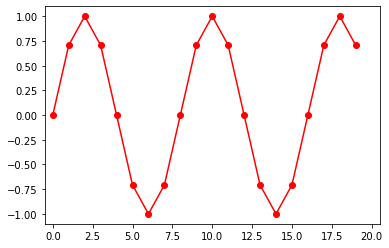

In [45]:
s = np.sin(2 * np.pi * 0.125 * np.arange(20))
plt.plot(s, 'ro-')
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.show()

####  1.1 Target 데이터를 설정합니다.

In [46]:
X_train = []
Y_train = []
sequence_length = 3
print('<input sequence>\t\t\t->\t\t\t<target>\n')
for i in range(0, len(s) - sequence_length):
    if i + sequence_length + 1 == 20:
        break
    x = s[i:i + sequence_length]
    y = s[i + sequence_length + 1]
    print(x, '->', y, '\n')

    X_train.append(x)
    Y_train.append(y)


<input sequence>			->			<target>

[0.         0.70710678 1.        ] -> 1.2246467991473532e-16 

[0.70710678 1.         0.70710678] -> -0.7071067811865475 

[1.00000000e+00 7.07106781e-01 1.22464680e-16] -> -1.0 

[ 7.07106781e-01  1.22464680e-16 -7.07106781e-01] -> -0.7071067811865477 

[ 1.22464680e-16 -7.07106781e-01 -1.00000000e+00] -> -2.4492935982947064e-16 

[-0.70710678 -1.         -0.70710678] -> 0.7071067811865474 

[-1.00000000e+00 -7.07106781e-01 -2.44929360e-16] -> 1.0 

[-7.07106781e-01 -2.44929360e-16  7.07106781e-01] -> 0.7071067811865483 

[-2.44929360e-16  7.07106781e-01  1.00000000e+00] -> 3.6739403974420594e-16 

[0.70710678 1.         0.70710678] -> -0.7071067811865479 

[1.00000000e+00 7.07106781e-01 3.67394040e-16] -> -1.0 

[ 7.07106781e-01  3.67394040e-16 -7.07106781e-01] -> -0.7071067811865485 

[ 3.67394040e-16 -7.07106781e-01 -1.00000000e+00] -> -4.898587196589413e-16 

[-0.70710678 -1.         -0.70710678] -> 0.7071067811865478 

[-1.00000000e+00 -7.0710678

\* 그래프로 확인하기

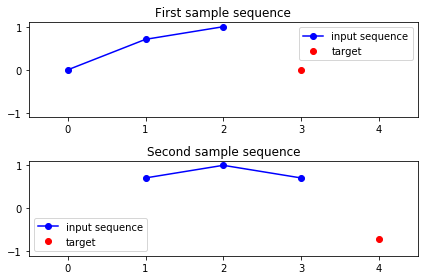

In [47]:
plt.subplot(211)
plt.plot([0, 1, 2], X_train[0].flatten(), 'bo-', label="input sequence")
plt.plot([3], Y_train[0], 'ro', label="target")
#그래프에 나타낼 x축 범위
plt.xlim(-0.5, 4.5)
#그래프에 나타낼 y축 범위
plt.ylim(-1.1, 1.1)
plt.legend()#범주
plt.title("First sample sequence")

plt.subplot(212)
plt.plot([1, 2, 3], X_train[1].flatten(), 'bo-', label="input sequence")
plt.plot([4], Y_train[1], 'ro', label="target")
#그래프에 나타낼 x축 범위
plt.xlim(-0.5, 4.5)
#그래프에 나타낼 y축 범위
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.tight_layout()

plt.show()

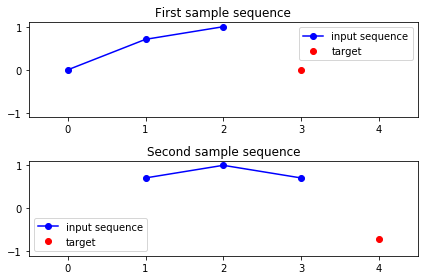

In [48]:
plt.subplot(211)
plt.plot([0, 1, 2], X_train[0], 'bo-', label="input sequence")
plt.plot([3], Y_train[0], 'ro', label="target")
#그래프에 나타낼 x축 범위
plt.xlim(-0.5, 4.5)
#그래프에 나타낼 y축 범위
plt.ylim(-1.1, 1.1)
plt.legend()#범주
plt.title("First sample sequence")

plt.subplot(212)
plt.plot([1, 2, 3], X_train[1], 'bo-', label="input sequence")
plt.plot([4], Y_train[1], 'ro', label="target")
#그래프에 나타낼 x축 범위
plt.xlim(-0.5, 4.5)
#그래프에 나타낼 y축 범위
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.tight_layout()

plt.show()

## 2. keras의 SimpleRNN을 이용해 순환신경망 만들어보기

#### Keras 에서 RNN 을 사용하려면 입력 데이터는 (nb_samples, timesteps, input_dim) 크기를 가지는 ndim=3인 3차원 텐서(tensor) 형태이어야 합니다.

+ nb_samples(= batch_size) : 자료의 수
+ timesteps(= sequemce length) : 순서열의 길이
+ input_dim(= data_dim) : 입력 벡터의 차원

여기서 단일 시계열 데이터 이므로 input_dim = 1이고, 

3 스텝 크기의 순서열을 사용하므로 timesteps = 3이며 

자료의 수는 16개로 nb_samples = 16 입니다.
<br><br>
<br><br>

#### 2.1 입력 데이터 구조 파라미터를 설정합니다.

In [49]:
# RNN의 입력 크기(one-hot size)
data_dim = 1

#순서열의 길이
sequence_length = len(X_train[0])# unfolding(unit 수)

#배치사이즈(one batch size)
# batch_size

# RNN cell의 출력 크기(차원)
# hidden_size = len(char_set) = num_classes

#### 데이터 구조를 변환합니다.

In [50]:
X_train = np.reshape(X_train, (-1, sequence_length, data_dim))

In [51]:
print(np.shape(X_train))
print(np.shape(Y_train))

(16, 3, 1)
(16,)


#### 2.2 학습

In [52]:
# 입력 텐서
input_shape = (X_train[0].shape)
input_tensor = layers.Input(input_shape)

In [53]:
input_tensor

<tf.Tensor 'input_3:0' shape=(?, 3, 1) dtype=float32>

In [54]:
# 가장 단순한 신경망 구조인 SimpleRNN 클래스를 사용합니다.
# 첫번째 인수 : RNN cell 출력의 크기(차원)를 입력합니다.

rnn_layer = layers.SimpleRNN(10)(input_tensor)

# Dense 레이어를 통과시켜 Target의 차원과 layer의 ouput의 차원을 맞춰줍니다.
output_tensor = layers.Dense(1, activation="linear")(rnn_layer)

In [55]:
# 모델 컴파일.
model = models.Model(input_tensor, output_tensor)
model.compile(optimizer = 'Adam',
              # 예측값과 실제값 사이의 차이를 최소화하므로 mse
              loss = 'mse',
              metrics = ['mse'])

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


\* 학습 이전의 model 출력

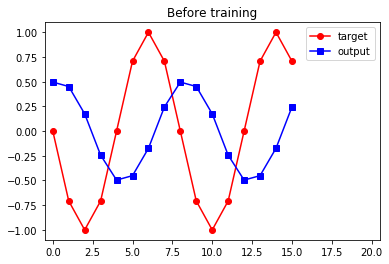

In [57]:
plt.plot(Y_train, 'ro-', label="target")
plt.plot(model.predict(X_train[:, :, :]), 'bs-', label="output")
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Before training")
plt.show()

In [58]:
history = model.fit(X_train, Y_train, epochs=100, verbose=2)

Epoch 1/100
 - 0s - loss: 0.7951 - mean_squared_error: 0.7951
Epoch 2/100
 - 0s - loss: 0.7694 - mean_squared_error: 0.7694
Epoch 3/100
 - 0s - loss: 0.7443 - mean_squared_error: 0.7443
Epoch 4/100
 - 0s - loss: 0.7196 - mean_squared_error: 0.7196
Epoch 5/100
 - 0s - loss: 0.6955 - mean_squared_error: 0.6955
Epoch 6/100
 - 0s - loss: 0.6718 - mean_squared_error: 0.6718
Epoch 7/100
 - 0s - loss: 0.6486 - mean_squared_error: 0.6486
Epoch 8/100
 - 0s - loss: 0.6260 - mean_squared_error: 0.6260
Epoch 9/100
 - 0s - loss: 0.6039 - mean_squared_error: 0.6039
Epoch 10/100
 - 0s - loss: 0.5822 - mean_squared_error: 0.5822
Epoch 11/100
 - 0s - loss: 0.5611 - mean_squared_error: 0.5611
Epoch 12/100
 - 0s - loss: 0.5406 - mean_squared_error: 0.5406
Epoch 13/100
 - 0s - loss: 0.5205 - mean_squared_error: 0.5205
Epoch 14/100
 - 0s - loss: 0.5009 - mean_squared_error: 0.5009
Epoch 15/100
 - 0s - loss: 0.4819 - mean_squared_error: 0.4819
Epoch 16/100
 - 0s - loss: 0.4633 - mean_squared_error: 0.4633
E

#### 2.3 학습 결과 확인

\* 학습을 후의 출력

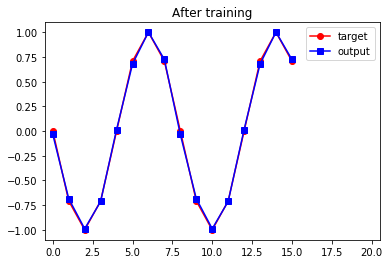

In [59]:
plt.plot(Y_train, 'ro-', label="target")
plt.plot(model.predict(X_train[:, :, :]), 'bs-', label="output")
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("After training")
plt.show()

### 실습 예제 2-2)  시계열 예측하기(many to many)

다음 3스텝의 순서열을 예측하도로 학습합니다.

## 1. 데이터 생성하기(데이터 살펴보기 + 간단한 전처리)

#### 예제 2)와 동일한 싸인파를 데이터로 사용합니다.

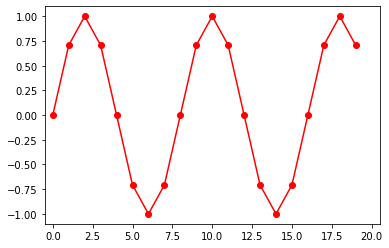

In [60]:
s = np.sin(2 * np.pi * 0.125 * np.arange(20))
plt.plot(s, 'ro-')
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.show()

####  1.1Target 데이터를 설정합니다.

In [61]:
X_train2 = []
Y_train2 = []
sequence_length = 3
print('<input sequence>\t\t\t->\t\t\t<target>\n')
for i in range(0, len(s) - sequence_length):
    if i + sequence_length == 18:
        break
    x = s[i:i + sequence_length]
    y = s[i + sequence_length:i + sequence_length * 2]
    print(x, '->', y, '\n')

    X_train2.append(x)
    Y_train2.append(y)


<input sequence>			->			<target>

[0.         0.70710678 1.        ] -> [ 7.07106781e-01  1.22464680e-16 -7.07106781e-01] 

[0.70710678 1.         0.70710678] -> [ 1.22464680e-16 -7.07106781e-01 -1.00000000e+00] 

[1.00000000e+00 7.07106781e-01 1.22464680e-16] -> [-0.70710678 -1.         -0.70710678] 

[ 7.07106781e-01  1.22464680e-16 -7.07106781e-01] -> [-1.00000000e+00 -7.07106781e-01 -2.44929360e-16] 

[ 1.22464680e-16 -7.07106781e-01 -1.00000000e+00] -> [-7.07106781e-01 -2.44929360e-16  7.07106781e-01] 

[-0.70710678 -1.         -0.70710678] -> [-2.44929360e-16  7.07106781e-01  1.00000000e+00] 

[-1.00000000e+00 -7.07106781e-01 -2.44929360e-16] -> [0.70710678 1.         0.70710678] 

[-7.07106781e-01 -2.44929360e-16  7.07106781e-01] -> [1.00000000e+00 7.07106781e-01 3.67394040e-16] 

[-2.44929360e-16  7.07106781e-01  1.00000000e+00] -> [ 7.07106781e-01  3.67394040e-16 -7.07106781e-01] 

[0.70710678 1.         0.70710678] -> [ 3.67394040e-16 -7.07106781e-01 -1.00000000e+00] 

[1.000

\* 그래프로 확인하기

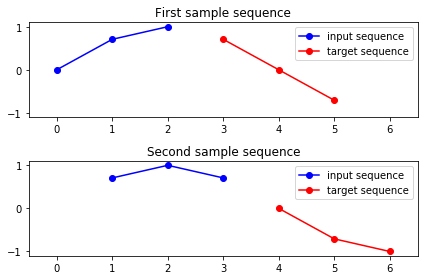

In [62]:
plt.subplot(211)
plt.plot([0, 1, 2], X_train2[0].flatten(), 'bo-', label="input sequence")
plt.plot([3, 4, 5], Y_train2[0].flatten(), 'ro-', label="target sequence")
#그래프에 나타낼 x축 범위
plt.xlim(-0.5, 6.5)
#그래프에 나타낼 y축 범위
plt.ylim(-1.1, 1.1)
plt.legend()#범주
plt.title("First sample sequence")
plt.subplot(212)
plt.plot([1, 2, 3], X_train2[1].flatten(), 'bo-', label="input sequence")
plt.plot([4, 5, 6], Y_train2[1].flatten(), 'ro-', label="target sequence")
#그래프에 나타낼 x축 범위
plt.xlim(-0.5, 6.5)
#그래프에 나타낼 y축 범위
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.tight_layout()
plt.show()

In [63]:
print(np.shape(X_train2))
print(np.shape(Y_train2))

(15, 3)
(15, 3)


## 2. keras의 SimpleRNN을 이용해 순환신경망 만들어보기

#### Keras 에서 RNN 을 사용하려면 입력 데이터는 (nb_samples, timesteps, input_dim) 크기를 가지는 ndim=3인 3차원 텐서(tensor) 형태이어야 합니다.

+ nb_samples(= batch_size) : 자료의 수
+ timesteps(= sequemce length) : 순서열의 길이
+ input_dim(= data_dim) : 입력 벡터의 차원

여기서 단일 시계열 데이터 이므로 input_dim = 1이고, 

3 스텝 크기의 순서열을 사용하므로 timesteps = 3이며 

자료의 수는 15개로 nb_samples = 15 입니다.
<br><br>
<br><br>

#### 2.1 입력 데이터 구조 파라미터를 설정합니다.

In [64]:
# RNN의 입력 크기(one-hot size)
data_dim = 1

#순서열의 길이
sequence_length = len(X_train[0])# unfolding(unit 수)

#배치사이즈(one batch size)
# batch_size

# RNN cell의 출력 크기(차원)
# hidden_size = len(char_set) = num_classes

#### 데이터 구조를 변환합니다.

In [65]:
X_train2 = np.reshape(X_train2, (-1, sequence_length, data_dim))

In [66]:
Y_train2 = np.reshape(Y_train2, (-1, sequence_length, data_dim))

In [67]:
print(np.shape(X_train2))
print(np.shape(Y_train2))

(15, 3, 1)
(15, 3, 1)


#### 2.2 학습

In [68]:
# 입력 텐서
input_shape = (X_train2[0].shape)
input_tensor = layers.Input(input_shape)

In [69]:
input_tensor

<tf.Tensor 'input_4:0' shape=(?, 3, 1) dtype=float32>

In [70]:
# 가장 단순한 신경망 구조인 SimpleRNN 클래스를 사용합니다.
# 첫번째 인수 : RNN cell 출력의 크기(차원)를 입력합니다.
# return_sequences : 출력 시퀀스의 마지막 출력을 반환할지 아니면 전체 시퀀스를 반환할지 지정합니다.
rnn_layer = layers.SimpleRNN(10, return_sequences=True)(input_tensor)

# 입력의 모든 시간 슬라이스에 Dense 레이어를 적용합니다.
# 데이터의 형태가 (32, 10, 18)이라고 한다면
# 자료의 수는 32, 순서열의 길이는 10, 입력 벡터의 차원은 18이라는 것을 나타냅니다.
# 이때 순서열 각각에 대해서 Dense 레이어를 통과시킵니다.
# Target의 차원과 layer의 ouput의 차원을 맞춰주는 것입니다,
output_tensor = layers.TimeDistributed(layers.Dense(1, activation='linear'))(rnn_layer)


In [71]:
# 모델 컴파일.
model2 = models.Model(input_tensor, output_tensor)
model2.compile(optimizer = 'Adam',
              # 예측값과 실제값 사이의 차이를 최소화하므로 mse
              loss = 'mse',
              metrics = ['mse'])

In [72]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 3, 10)             120       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 1)              11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


\* 학습 이전의 model 출력

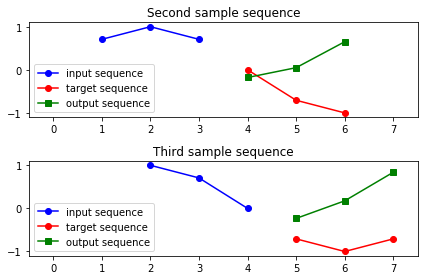

In [73]:
plt.subplot(211)
plt.plot([1, 2, 3], X_train2[1].flatten(), 'bo-', label="input sequence")
plt.plot([4, 5, 6], Y_train2[1].flatten(), 'ro-', label="target sequence")
plt.plot([4, 5, 6], model2.predict(X_train2[1:2, :, :]
                                   ).flatten(), 'gs-', label="output sequence")
plt.xlim(-0.5, 7.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.subplot(212)
plt.plot([2, 3, 4], X_train2[2].flatten(), 'bo-', label="input sequence")
plt.plot([5, 6, 7], Y_train2[2].flatten(), 'ro-', label="target sequence")
plt.plot([5, 6, 7], model2.predict(X_train2[2:3, :, :]
                                   ).flatten(), 'gs-', label="output sequence")
plt.xlim(-0.5, 7.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Third sample sequence")
plt.tight_layout()
plt.show()

In [74]:
history = model2.fit(X_train2, Y_train2, epochs=100, verbose=2)

Epoch 1/100
 - 0s - loss: 0.8865 - mean_squared_error: 0.8865
Epoch 2/100
 - 0s - loss: 0.8670 - mean_squared_error: 0.8670
Epoch 3/100
 - 0s - loss: 0.8479 - mean_squared_error: 0.8479
Epoch 4/100
 - 0s - loss: 0.8292 - mean_squared_error: 0.8292
Epoch 5/100
 - 0s - loss: 0.8108 - mean_squared_error: 0.8108
Epoch 6/100
 - 0s - loss: 0.7928 - mean_squared_error: 0.7928
Epoch 7/100
 - 0s - loss: 0.7751 - mean_squared_error: 0.7751
Epoch 8/100
 - 0s - loss: 0.7579 - mean_squared_error: 0.7579
Epoch 9/100
 - 0s - loss: 0.7410 - mean_squared_error: 0.7410
Epoch 10/100
 - 0s - loss: 0.7245 - mean_squared_error: 0.7245
Epoch 11/100
 - 0s - loss: 0.7084 - mean_squared_error: 0.7084
Epoch 12/100
 - 0s - loss: 0.6926 - mean_squared_error: 0.6926
Epoch 13/100
 - 0s - loss: 0.6772 - mean_squared_error: 0.6772
Epoch 14/100
 - 0s - loss: 0.6622 - mean_squared_error: 0.6622
Epoch 15/100
 - 0s - loss: 0.6475 - mean_squared_error: 0.6475
Epoch 16/100
 - 0s - loss: 0.6331 - mean_squared_error: 0.6331
E

#### 2.3 학습 결과 확인

\* 학습을 후의 출력

In [75]:
plt.subplot(211)
plt.plot([1, 2, 3], X_train2[1].flatten(), 'bo-', label="input sequence")
plt.plot([4, 5, 6], Y_train2[1].flatten(), 'ro-', label="target sequence")
plt.plot([4, 5, 6], model2.predict(X_train2[1:2, :, :]
                                   ).flatten(), 'gs-', label="output sequence")
plt.xlim(-0.5, 7.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.subplot(212)
plt.plot([2, 3, 4], X_train2[2].flatten(), 'bo-', label="input sequence")
plt.plot([5, 6, 7], Y_train2[2].flatten(), 'ro-', label="target sequence")
plt.plot([5, 6, 7], model2.predict(X_train2[2:3, :, :]
                                   ).flatten(), 'gs-', label="output sequence")
plt.xlim(-0.5, 7.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Third sample sequence")
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-75-55384daea628>, line 20)

# 장단기 기억 모형(Long short-term memory, LSTM)
 
+ 현재 시점을 예측하는데 필요한 문맥이 가까이 있고 많지 않다면 RNN은 이를 학습할 수 있습니다. 하지만, 정보를 필요로하는 시점과, 필요한 정보가 멀리 떨어져있다면 RNN은 잘 예측할 수 없게 됩니다. 이 문제를 __"Long-term dependency"__라고 하며 이를 해결하기 위해 고안된 것이 LSTM입니다.


+ 이렇게 학습능력이 크게 저하되는 것은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 경사가 점차 줄기 때문입니다. 그렇기 때문에 경사 소실 문제(Vanishing gradient problem)라고도 합니다

## LSTM은 RNN의 히든 state에 cell-state를 추가한 구조입니다.

<img src="./Images/LSTM.png">

__cell state는 state가 시간이 오래 경과하더라도 경사가 비교적 잘 전파되도록 합니다.__

<img src="./Images/forgetgate.png">
1\. forget gate(망각게이트) : '과거 정보를 잊기'를 위한 게이트

망각게이트는 t시점에서의 입력값($x_t$)과 이전 t−1시점에서의 출력값($h_{t-1}$)을 입력받아 이전 셀의 정보를 망각할지 말지 결정합니다.

망각게이트의 출력값 : $f_t = \sigma{(W_f[h_{t-1},x_t]+b_f)}$

($\sigma$ : 시그모이드 함수, $W_f$ : 망각게이트의 가중치. $b_f$: 바이어스 )

<img src="./Images/inputgate.png">

2\. input gate(입력게이트):'현재 정보를 기억하기'위한 게이트

입력게이트는  t시점에서의 입력값($x_t$)과 이전 t−1시점에서의 출력값($h_{t-1}$)을 입력받고 현재의 정보를 다음 시점으로 전해질 cell state에 얼마나 반영할 지를 결정합니다.

입력게이트의 출력값 : $i_t = \sigma{(W_i[h_{t-1},x_t]+b_i)}$

($\sigma$ : 시그모이드 함수, $W_i$ : 입력게이트의 가중치. $b_i$: 바이어스 )

<img src="./Images/combination.png">

3\. cell state 갱신

입력값($x_t$)과 이전 t−1시점에서의 출력값($h_{t-1}$) 을 입력받고 하이퍼탄젠트 함수를 사용해  $\tilde{C}_t$ 를 생성하고 입력게이트의 출력과 Hadamard 곱 (⊙) 을 합니다.
그리고 이 값과 망각게이트의 출력을 이용해 cell state를 다음 수식과 같이 갱신합니다.

(⊙는 요소별 곱셈을 뜻하는 Hadamard product 연산자입니다.)

$\tilde{C}_t = tanh(W_c[h_{t-1},x_t]+b_c)$

($W_c$ : 셀 상태 가중치. $b_c$: 바이어스 )

$C_t = C_{t-1}⊙f_t+i_t⊙\tilde{C}_t$

<img src="./Images/outputgate.png">

4\. 현재 셀의 출력값 계산

현재 셀의 출력값 $h_t$는 다음 수식과 같이 계산합니다.

$o_t = \sigma{(W_o[h_{t-1},x_t]+b_0)}$

$h_t = o_t⊙tanh(C_t) $

### Reference
+ https://github.com/hunkim/DeepLearningZeroToAll
 
+ https://datascienceschool.net
 
+ http://colah.github.io/posts/2015-08-Understanding-LSTMs/